## Example Experiment ##
### Dataset: Labeled Faces in the Wild ###
### Experiment: Two party training for gender classification ###

In [1]:
import simulator.server as server
import simulator.workerclass as worker
import simulator.workerhandler as wh
import topology_utils as tu

from collections import OrderedDict
import pandas as pd
import numpy as np
import copy
import os
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

/home/sattvik/envs/pytorch_env/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sattvik/envs/pytorch_env/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sattvik/envs/pytorch_env/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sattvik/envs/pytorch_env/lib/py

## Parameters ##

In [2]:
epochs = 50
batch_size = 64
learning_rate = 0.001
server_learning_rate = 0.01
num_workers = 2
local_iterations = 2

data_path = '../data/lfw/data/'

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/experiment_2')

## Divide Data between workers ##

In [3]:
attributes_df = pd.read_csv(data_path+'lfw_attributes.txt')

all_names = attributes_df.person.unique()
tt_msk = np.random.rand(len(all_names)) < 0.8
temp_train_names = all_names[tt_msk]
test_names = all_names[~tt_msk]
del all_names, tt_msk
train_val_df = attributes_df.loc[attributes_df['person'].isin(temp_train_names)]
test_df = attributes_df.loc[attributes_df['person'].isin(test_names)]

# add column to indicate split
train_val_df['target'] = 0
# allocate half the people to the target
names = train_val_df['person'].drop_duplicates()
target_worker_names = names.sample(frac=1)[:int(len(names)/2)]
target_worker_names = target_worker_names.reset_index(drop=True)

# populate target field
for index, row in train_val_df.iterrows():
    if row['person'] in target_worker_names.values:
        train_val_df['target'][index] = 1

# print distribution of data
print("entries with worker 1: {}, entries with worker 2: {}, entries in training set: {}, total entries: {}".format(sum(train_val_df['target']==1), sum(train_val_df['target']==0), len(test_df), len(attributes_df)))

/home/sattvik/envs/pytorch_env/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/sattvik/envs/pytorch_env/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/sattvik/envs/pytorch_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

entries with worker 1: 4890, entries with worker 2: 5331, entries in training set: 2922, total entries: 13143


## Define dataset class ##

In [4]:
class LFWDataset(Dataset):
    """LFW dataset."""

    def __init__(self, data_path, attributes_df, transform=None):
        self.attributes_df = attributes_df
        self.data_path = data_path
        self.transform = transform

    def __len__(self):
        return len(self.attributes_df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_path, "lfw_home/lfw_funneled", self.attributes_df.iloc[idx]['person'].replace(' ', '_'),"{}_{:04d}.jpg".format(self.attributes_df.iloc[idx]['person'].replace(' ', '_'),self.attributes_df.iloc[idx]['imagenum']))
#         img = torch.from_numpy(cv2.imread(img_path))
        img = Image.open(img_path, mode='r')
        
        label = self.attributes_df.iloc[idx]['Male']>0
        
        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.float)

## Define Model ##

In [5]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.rnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet50', pretrained=True)
        self.rnet.fc = nn.Linear(2048, 1)
        
        for p in self.parameters():
            p.requires_grad = False

        for p in self.rnet.fc.parameters():
            p.requires_grad = True

    def forward(self, x):
        x = torch.sigmoid(self.rnet(x))
        return x
    
    def unfreeze_layer4(self):
        for p in self.rnet.layer4.parameters():
            p.requires_grad = True

    def unfreeze_layer3(self):
        for p in self.rnet.layer3.parameters():
            p.requires_grad = True

    def unfreeze_layer2(self):
        for p in self.rnet.layer2.parameters():
            p.requires_grad = True

    def unfreeze_layer1(self):
        for p in self.rnet.layer1.parameters():
            p.requires_grad = True

def define_model():
    return ResNet()

## Training, Validation, and Evaluation functions ##

In [22]:
def perform_evaluation(val_model, dataloader):
    with torch.no_grad():
        epoch_loss = 0
        epoch_accuracy = 0
        for batch_idx, (data, target) in tqdm_notebook(enumerate(dataloader), total=len(dataloader)):
            # move data batch to GPU
#             data = data.cuda()
#             target = target.cuda()
            # forward pass
            output = val_model(data)
            loss = F.binary_cross_entropy(output, target.unsqueeze(1))
            # compute average loss an accuracy
            output = output.to('cpu')
            target = target.to('cpu')
            current_acc = torch.tensor(((output>0.5)== torch.tensor(target.unsqueeze(1), dtype=torch.bool)).sum(), dtype=torch.float)/torch.tensor(len(target), dtype=torch.float)
            epoch_loss = ((epoch_loss*batch_idx) + loss.item())/(batch_idx+1)
            epoch_accuracy = ((epoch_accuracy*batch_idx) + current_acc.item())/(batch_idx+1)
    print("testing loss: {} and testing accuracy: {}".format(epoch_loss, epoch_accuracy))
    return epoch_loss, epoch_accuracy

In [7]:
def perform_validation(val_model, dataloader):
    with torch.no_grad():
        epoch_loss = 0
        epoch_accuracy = 0
        for batch_idx, (data, target) in tqdm_notebook(enumerate(dataloader), total=len(dataloader)):
            # move data batch to GPU
            data = data.cuda()
            target = target.cuda()
            # forward pass
            output = val_model(data)
#             print(output, target.unsqueeze(1))
            loss = F.binary_cross_entropy(output, target.unsqueeze(1))
            # compute average loss an accuracy
            output = output.to('cpu')
            target = target.to('cpu')
            current_acc = torch.tensor(((output>0.5)== torch.tensor(target.unsqueeze(1), dtype=torch.bool)).sum(), dtype=torch.float)/torch.tensor(len(target), dtype=torch.float)
            epoch_loss = ((epoch_loss*batch_idx) + loss.item())/(batch_idx+1)
            epoch_accuracy = ((epoch_accuracy*batch_idx) + current_acc.item())/(batch_idx+1)
    print("val loss: {} and val accuracy: {}".format(epoch_loss, epoch_accuracy))
    return epoch_loss, epoch_accuracy

In [8]:
def perform_training(val_model, dataloader, optimizer):
    epoch_loss = 0
    epoch_accuracy = 0
    for batch_idx, (data, target) in tqdm_notebook(enumerate(dataloader), total=len(dataloader)):
        # move data batch to GPU
        data = data.cuda()
        target = target.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward pass
        output = val_model(data)
        loss = F.binary_cross_entropy(output, target.unsqueeze(1))
        # backward pass
        loss.backward()
        optimizer.step()
        # compute average loss an accuracy
        output = output.to('cpu')
        target = target.to('cpu')
        current_acc = torch.tensor(((output>0.5)== torch.tensor(target.unsqueeze(1), dtype=torch.bool)).sum(), dtype=torch.float)/torch.tensor(len(target), dtype=torch.float)
        epoch_loss = ((epoch_loss*batch_idx) + loss.item())/(batch_idx+1)
        epoch_accuracy = ((epoch_accuracy*batch_idx) + current_acc.item())/(batch_idx+1)
    print("train loss: {} and train accuracy: {}".format(epoch_loss, epoch_accuracy))
    return epoch_loss, epoch_accuracy

## Declare genuine worker ##

In [9]:
class target_worker(worker.base_workerclass):
    def __init__(self, name, attributes_df, model):
        super().__init__(name, False)
        self.worker_attributes_df = attributes_df[attributes_df['target']==1]
        print("initializing genuine worker node with ",len(self.worker_attributes_df)," data points")
        self.model = model
        self.local_iters = local_iterations
        # train val split
        all_names = self.worker_attributes_df.person.unique()
        tt_msk = np.random.rand(len(all_names)) < 0.8
        train_names = all_names[tt_msk]
        val_names = all_names[~tt_msk]
        del all_names, tt_msk
        
        # set optimizer
        self.set_optim()
        # create train val and test dataframes
        train_df = self.worker_attributes_df.loc[self.worker_attributes_df['person'].isin(train_names)]
        val_df = self.worker_attributes_df.loc[self.worker_attributes_df['person'].isin(val_names)]
        
        train_dataset = LFWDataset(data_path, train_df, transform=transforms.Compose([
                                                    transforms.RandomResizedCrop(224),
                                                    transforms.RandomHorizontalFlip(),
                                                    transforms.ToTensor()
                                                    ]))
        val_dataset = LFWDataset(data_path, val_df, transform=transforms.Compose([
                                                            transforms.RandomResizedCrop(224),
                                                            transforms.RandomHorizontalFlip(),
                                                            transforms.ToTensor()]))
        del train_df, val_df
        
        self.train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        self.val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        print(len(self.train_dataloader), len(self.val_dataloader))
    
    def set_param(self, w):
        self.model.load_state_dict(w)
    
    def get_params(self):
        return self.model.state_dict()
    
    def set_optim(self):
        self.optim = optim.Adam(self.model.parameters(), lr=learning_rate)
    
    def client_update(self, global_epoch):
        global writer
        self.model = self.model.cuda()
        prev_w = copy.deepcopy(self.model.state_dict())
        # unfreeze layers
        if 5 == global_epoch:
            self.model.unfreeze_layer3()
        if 20 == global_epoch:
            self.model.unfreeze_layer2()
        if 50 == global_epoch:
            self.model.unfreeze_layer1()
        for epoch in range(self.local_iters):
            # run train and val epochs
            print("sub-epoch: {}".format(epoch))
            self.model.train()
            train_loss, train_acc = perform_training(self.model, self.train_dataloader, self.optim)
            writer.add_scalar('training loss_'+self.name, train_loss, (global_epoch*self.local_iters)+epoch)
            writer.add_scalar('training accuracy_'+self.name, train_acc, (global_epoch*self.local_iters)+epoch)
            self.model.eval()
            val_loss, val_acc = perform_validation(self.model, self.val_dataloader)
            writer.add_scalar('validation loss_'+self.name, val_loss, (global_epoch*self.local_iters)+epoch)
            writer.add_scalar('validation accuracy_'+self.name, val_acc, (global_epoch*self.local_iters)+epoch)
        graddif = OrderedDict()
        for (item1, item2) in zip(self.model.state_dict().items(),prev_w.items()):
            key1=item1[0]
            value1=item1[1]
            key2=item2[0]
            value2=item2[1]
            diffval = value1-value2
            graddif.update({key1:diffval.cpu()})
        self.model = self.model.cpu()
        return graddif

## Declare malicious worker ##

In [10]:
# class malicious_worker(worker.base_workerclass):
#     def __init__(self, attributes_df, model):
#         super().__init__(True)
#         self.worker_attributes_df = attributes_df[attributes_df['target']==0]
#         print("initializing malicious worker node with ",len(self.worker_attributes_df)," data points")
#         self.model = model
#         self.local_iters = 5
    
#     def set_param(self, w):
#         self.model.load_state_dict(w)
    
#     def set_optim(self):
#         self.optim = optim.Adam(self.model.parameters(), lr=learning_rate)
    
#     def client_update(self):
#         print('ss')

## Initialize components of our simulations ##

In [11]:
server1 = server.server(server_learning_rate)
workers = wh.workerhandler([target_worker("w1", train_val_df,define_model()),target_worker("w2", train_val_df,define_model())])

Using cache found in /home/sattvik/.cache/torch/hub/pytorch_vision_v0.5.0


initializing genuine worker node with  4890  data points
60 17


Using cache found in /home/sattvik/.cache/torch/hub/pytorch_vision_v0.5.0


initializing genuine worker node with  4890  data points
60 18


In [12]:
tm = tu.topology_manager()

## Define network topology ##

In [13]:
tm.connect_star(server1, workers.get_all_workers())

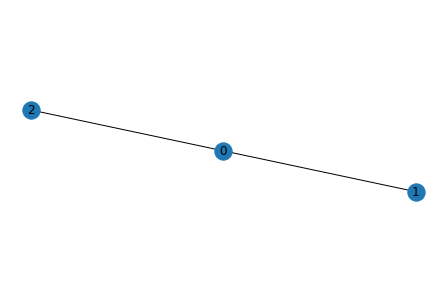

In [14]:
plot = tm.plot_topology()

## Start Training ##

In [15]:
# initialize server weights as model average
server1.set_init_weights(workers.get_average_weights())

# start training
for epoch in range(epochs):
    print("Epoch: ", epoch)
    new_grad = workers.perform_updates(epoch)
    new_w = server1.aggregate(new_grad)
    workers.set_param(new_w)

Epoch:  0
training on worker:  w1
sub-epoch: 0


/home/sattvik/envs/pytorch_env/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



train loss: 0.47101569175720215 and train accuracy: 0.7973958333333333


/home/sattvik/envs/pytorch_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()



val loss: 0.4139839778928196 and val accuracy: 0.8017949812552508
sub-epoch: 1



train loss: 0.36870569263895353 and train accuracy: 0.8560639878114065



val loss: 0.3447013216860154 and val accuracy: 0.84877811459934
training on worker:  w2
sub-epoch: 0



train loss: 0.4838387608528136 and train accuracy: 0.7783854166666667



val loss: 0.36852969974279404 and val accuracy: 0.8845486111111112
sub-epoch: 1



train loss: 0.3764204824964205 and train accuracy: 0.8536458333333333



val loss: 0.33214857760402894 and val accuracy: 0.8501736124356588
Epoch:  1
training on worker:  w1
sub-epoch: 0



train loss: 0.4655183916290603 and train accuracy: 0.8058407733837764



val loss: 0.3781972282073077 and val accuracy: 0.8745134087169871
sub-epoch: 1



train loss: 0.35976434548695874 and train accuracy: 0.8573660711447398



val loss: 0.3262021822087905 and val accuracy: 0.8724589102408465
training on worker:  w2
sub-epoch: 0



train loss: 0.46552675763765977 and train accuracy: 0.7984375



val loss: 0.360047514239947 and val accuracy: 0.8303819447755814
sub-epoch: 1



train loss: 0.3659073645869891 and train accuracy: 0.8497395833333333



val loss: 0.3353847886125247 and val accuracy: 0.8854166666666666
Epoch:  2
training on worker:  w1
sub-epoch: 0



train loss: 0.4756016011039414 and train accuracy: 0.7914434522390367



val loss: 0.37162600370014415 and val accuracy: 0.875216263182023
sub-epoch: 1



train loss: 0.37149382879336673 and train accuracy: 0.8537202378114065



val loss: 0.3584287341903238 and val accuracy: 0.863159600426169
training on worker:  w2
sub-epoch: 0



train loss: 0.4681118706862132 and train accuracy: 0.7906250000000001



val loss: 0.36140620708465576 and val accuracy: 0.8442708320087857
sub-epoch: 1



train loss: 0.365933446586132 and train accuracy: 0.8557291666666667



val loss: 0.3150935640765561 and val accuracy: 0.8810763888888888
Epoch:  3
training on worker:  w1
sub-epoch: 0



train loss: 0.4692443867524464 and train accuracy: 0.7904389878114064



val loss: 0.38592443921986747 and val accuracy: 0.8206098605604732
sub-epoch: 1



train loss: 0.35223153407375013 and train accuracy: 0.8608258932828903



val loss: 0.3222586337257834 and val accuracy: 0.8706206749467289
training on worker:  w2
sub-epoch: 0



train loss: 0.4877896179755528 and train accuracy: 0.7908854166666667



val loss: 0.3859141700797611 and val accuracy: 0.888541665342119
sub-epoch: 1



train loss: 0.35975470046202335 and train accuracy: 0.85859375



val loss: 0.33042870710293454 and val accuracy: 0.8897569444444444
Epoch:  4
training on worker:  w1
sub-epoch: 0



train loss: 0.4757654617230098 and train accuracy: 0.7891369044780732



val loss: 0.373137446010814 and val accuracy: 0.8333693777813631
sub-epoch: 1



train loss: 0.3576871007680893 and train accuracy: 0.8594494044780732



val loss: 0.342113898080938 and val accuracy: 0.8554282013107749
training on worker:  w2
sub-epoch: 0



train loss: 0.47465896904468546 and train accuracy: 0.7940104166666665



val loss: 0.34431258837382 and val accuracy: 0.8720486097865634
sub-epoch: 1



train loss: 0.3670228821535905 and train accuracy: 0.8598958333333332



val loss: 0.3324068321122064 and val accuracy: 0.8760416673289405
Epoch:  5
training on worker:  w1
sub-epoch: 0



train loss: 0.3849040925502777 and train accuracy: 0.8355282733837763



val loss: 0.3404557888998705 and val accuracy: 0.8890030278879053
sub-epoch: 1



train loss: 0.3006399040420849 and train accuracy: 0.8847470233837763



val loss: 0.29859565549037037 and val accuracy: 0.8838127150255091
training on worker:  w2
sub-epoch: 0



train loss: 0.3854910251994928 and train accuracy: 0.8317708333333333



val loss: 0.5162932243612077 and val accuracy: 0.8355902764532301
sub-epoch: 1



train loss: 0.3072791919112205 and train accuracy: 0.8830729166666667



val loss: 0.2901238592134582 and val accuracy: 0.8881944451067183
Epoch:  6
training on worker:  w1
sub-epoch: 0



train loss: 0.3912722607453664 and train accuracy: 0.8312872022390365



val loss: 0.37889936654006734 and val accuracy: 0.8879757768967572
sub-epoch: 1



train loss: 0.28683600276708604 and train accuracy: 0.8930431544780731



val loss: 0.34352098405361176 and val accuracy: 0.8581855542519513
training on worker:  w2
sub-epoch: 0



train loss: 0.4013640103240808 and train accuracy: 0.8265625



val loss: 0.3678494000600444 and val accuracy: 0.8498263888888888
sub-epoch: 1



train loss: 0.30831340700387955 and train accuracy: 0.88046875



val loss: 0.28569347908099485 and val accuracy: 0.8977430562178293
Epoch:  7
training on worker:  w1
sub-epoch: 0



train loss: 0.39377210115393 and train accuracy: 0.8297991067171097



val loss: 6.017343549167409 and val accuracy: 0.27638408366371603
sub-epoch: 1



train loss: 0.3032351300120354 and train accuracy: 0.8844494044780731



val loss: 0.2933477207141764 and val accuracy: 0.9011678204816931
training on worker:  w2
sub-epoch: 0



train loss: 0.4198704513410727 and train accuracy: 0.8153645833333333



val loss: 0.5032074501117071 and val accuracy: 0.7604166666666666
sub-epoch: 1



train loss: 0.3084415726363659 and train accuracy: 0.8864583333333333



val loss: 0.27749350832568276 and val accuracy: 0.8980902764532301
Epoch:  8
training on worker:  w1
sub-epoch: 0



train loss: 0.41634474247694025 and train accuracy: 0.8182291666666667



val loss: 0.4358776650008033 and val accuracy: 0.8277465385549209
sub-epoch: 1



train loss: 0.30997997025648755 and train accuracy: 0.874851190050443



val loss: 0.3683638143188813 and val accuracy: 0.832342126790215
training on worker:  w2
sub-epoch: 0



train loss: 0.3918318599462509 and train accuracy: 0.8247395833333333



val loss: 1.1949890388382807 and val accuracy: 0.49704861144224805
sub-epoch: 1



train loss: 0.30862370232741043 and train accuracy: 0.88515625



val loss: 0.35742708875073326 and val accuracy: 0.8628472222222222
Epoch:  9
training on worker:  w1
sub-epoch: 0



train loss: 0.40785345087448754 and train accuracy: 0.8308779766162236



val loss: 1.627554690136629 and val accuracy: 0.4540441176470588
sub-epoch: 1



train loss: 0.3021006966630619 and train accuracy: 0.8843377977609634



val loss: 0.2854546869502348 and val accuracy: 0.8918685106670156
training on worker:  w2
sub-epoch: 0



train loss: 0.41969193642338115 and train accuracy: 0.81171875



val loss: 0.7696754601266649 and val accuracy: 0.697395834657881
sub-epoch: 1



train loss: 0.298656906435887 and train accuracy: 0.8890625



val loss: 0.4088149658507771 and val accuracy: 0.8503472208976746
Epoch:  10
training on worker:  w1
sub-epoch: 0



train loss: 0.41700219313303627 and train accuracy: 0.818601190050443



val loss: 1.5559700236600988 and val accuracy: 0.5780168701620663
sub-epoch: 1



train loss: 0.30016557251413656 and train accuracy: 0.8903273810942968



val loss: 0.5256949435262119 and val accuracy: 0.7730320060954374
training on worker:  w2
sub-epoch: 0



train loss: 0.43212798436482747 and train accuracy: 0.8104166666666668



val loss: 0.38215285829371876 and val accuracy: 0.8498263888888888
sub-epoch: 1



train loss: 0.30434483488400776 and train accuracy: 0.884375



val loss: 0.33997146868043476 and val accuracy: 0.8626736104488373
Epoch:  11
training on worker:  w1
sub-epoch: 0



train loss: 0.4139574157694975 and train accuracy: 0.8162946432828904



val loss: 0.7211508785977083 and val accuracy: 0.7853589969522813
sub-epoch: 1



train loss: 0.3133867378036181 and train accuracy: 0.880617559949557



val loss: 0.263664300827419 and val accuracy: 0.8984104675405166
training on worker:  w2
sub-epoch: 0



train loss: 0.43120896369218825 and train accuracy: 0.8125



val loss: 0.9991772605313195 and val accuracy: 0.5355902777777778
sub-epoch: 1



train loss: 0.3213638012607891 and train accuracy: 0.8752604166666667



val loss: 0.36195219225353664 and val accuracy: 0.8522569437821707
Epoch:  12
training on worker:  w1
sub-epoch: 0



train loss: 0.4353931506474813 and train accuracy: 0.8037946432828903



val loss: 1.7339986212113325 and val accuracy: 0.41208910065538745
sub-epoch: 1



train loss: 0.3204009845852853 and train accuracy: 0.8759672621885936



val loss: 0.37181394328089323 and val accuracy: 0.8634839969522813
training on worker:  w2
sub-epoch: 0



train loss: 0.44663203954696656 and train accuracy: 0.796875



val loss: 4.629724595281813 and val accuracy: 0.283680555721124
sub-epoch: 1



train loss: 0.31859296187758446 and train accuracy: 0.8791666666666667



val loss: 0.2885836238662402 and val accuracy: 0.8845486111111112
Epoch:  13
training on worker:  w1
sub-epoch: 0



train loss: 0.4522875607013704 and train accuracy: 0.8058779766162236



val loss: 0.4499978896449594 and val accuracy: 0.7984429071931278
sub-epoch: 1



train loss: 0.32824723770221076 and train accuracy: 0.8716517855723699



val loss: 0.32525646072976727 and val accuracy: 0.8682958483695984
training on worker:  w2
sub-epoch: 0



train loss: 0.44368443662921586 and train accuracy: 0.80390625



val loss: 3.4302156236436634 and val accuracy: 0.2776041668322351
sub-epoch: 1



train loss: 0.3179864421486854 and train accuracy: 0.878125



val loss: 0.29676292919450337 and val accuracy: 0.8812500006622739
Epoch:  14
training on worker:  w1
sub-epoch: 0



train loss: 0.4724062937001386 and train accuracy: 0.8013020833333333



val loss: 2.1547080629012165 and val accuracy: 0.35040008671143474
sub-epoch: 1



train loss: 0.30913787682851157 and train accuracy: 0.888430059949557



val loss: 0.28078899751691255 and val accuracy: 0.894625863608192
training on worker:  w2
sub-epoch: 0



train loss: 0.45426522791385643 and train accuracy: 0.7921875



val loss: 1.062163104613622 and val accuracy: 0.627083334657881
sub-epoch: 1



train loss: 0.3224534469346205 and train accuracy: 0.8729166666666667



val loss: 0.2804204904370838 and val accuracy: 0.896354165342119
Epoch:  15
training on worker:  w1
sub-epoch: 0



train loss: 0.4598845884203911 and train accuracy: 0.7933779766162237



val loss: 0.3685046697364134 and val accuracy: 0.8525627150255091
sub-epoch: 1



train loss: 0.315045228600502 and train accuracy: 0.8784598211447397



val loss: 0.3351707458496094 and val accuracy: 0.8719723189578337
training on worker:  w2
sub-epoch: 0



train loss: 0.46311598370472584 and train accuracy: 0.7955729166666667



val loss: 0.5849678665399551 and val accuracy: 0.7397569451067183
sub-epoch: 1



train loss: 0.34061928068598113 and train accuracy: 0.8645833333333334



val loss: 0.3046277699371179 and val accuracy: 0.8784722222222222
Epoch:  16
training on worker:  w1
sub-epoch: 0



train loss: 0.4422087378799915 and train accuracy: 0.8074404766162236



val loss: 0.2966540745076011 and val accuracy: 0.8862456749467289
sub-epoch: 1



train loss: 0.2964780638615291 and train accuracy: 0.8903273810942968



val loss: 0.30376096332774444 and val accuracy: 0.8763516440111048
training on worker:  w2
sub-epoch: 0



train loss: 0.4385457488397757 and train accuracy: 0.80234375



val loss: 0.8643910189469656 and val accuracy: 0.6022569437821707
sub-epoch: 1



train loss: 0.3160872680445512 and train accuracy: 0.8763020833333334



val loss: 0.28473708033561707 and val accuracy: 0.8928819431198968
Epoch:  17
training on worker:  w1
sub-epoch: 0



train loss: 0.47123964702089616 and train accuracy: 0.791555059949557



val loss: 0.5799310610574835 and val accuracy: 0.7332396191709182
sub-epoch: 1



train loss: 0.3080770209431647 and train accuracy: 0.8846354166666667



val loss: 0.31194938105695386 and val accuracy: 0.8892192910699284
training on worker:  w2
sub-epoch: 0



train loss: 0.5007938538988435 and train accuracy: 0.75703125



val loss: 0.44988428552945453 and val accuracy: 0.8125
sub-epoch: 1



train loss: 0.34946084941426914 and train accuracy: 0.8619791666666666



val loss: 0.342557854950428 and val accuracy: 0.8633680542310079
Epoch:  18
training on worker:  w1
sub-epoch: 0



train loss: 0.46613541344801596 and train accuracy: 0.7944196432828903



val loss: 0.3479919275816749 and val accuracy: 0.8698096871376038
sub-epoch: 1



train loss: 0.31810787916183475 and train accuracy: 0.87734375



val loss: 0.2991868511718862 and val accuracy: 0.8845155694905449
training on worker:  w2
sub-epoch: 0



train loss: 0.46933658272027956 and train accuracy: 0.7893229166666667



val loss: 0.8630277613798777 and val accuracy: 0.5555555555555556
sub-epoch: 1



train loss: 0.3411656650404136 and train accuracy: 0.8640625



val loss: 0.29616693324512905 and val accuracy: 0.8836805555555556
Epoch:  19
training on worker:  w1
sub-epoch: 0



train loss: 0.47553717643022547 and train accuracy: 0.7795014878114066



val loss: 0.44049377827083364 and val accuracy: 0.8008217986892251
sub-epoch: 1



train loss: 0.34488493402798964 and train accuracy: 0.8701264878114064



val loss: 0.3368156885399538 and val accuracy: 0.8580774209078621
training on worker:  w2
sub-epoch: 0



train loss: 0.4632772624492644 and train accuracy: 0.7885416666666667



val loss: 0.7979446318414476 and val accuracy: 0.5265625003311368
sub-epoch: 1



train loss: 0.3043021626770496 and train accuracy: 0.8833333333333333



val loss: 0.3371860682964325 and val accuracy: 0.8647569451067183
Epoch:  20
training on worker:  w1
sub-epoch: 0



train loss: 0.4837690512339274 and train accuracy: 0.7876860121885936



val loss: 0.6342476606369019 and val accuracy: 0.6500865045715781
sub-epoch: 1



train loss: 0.35814959208170577 and train accuracy: 0.8529389878114064



val loss: 0.4232174964512096 and val accuracy: 0.8086613311487085
training on worker:  w2
sub-epoch: 0



train loss: 0.4928501874208449 and train accuracy: 0.771875



val loss: 0.5024034364355936 and val accuracy: 0.7414930562178293
sub-epoch: 1



train loss: 0.3659817616144816 and train accuracy: 0.8533854166666667



val loss: 0.30136539828446174 and val accuracy: 0.8897569444444444
Epoch:  21
training on worker:  w1
sub-epoch: 0



train loss: 0.4703063187499839 and train accuracy: 0.7993303567171097



val loss: 0.43556538925451393 and val accuracy: 0.8340722322463989
sub-epoch: 1



train loss: 0.3359676316380502 and train accuracy: 0.8693452378114065



val loss: 0.29166419365826773 and val accuracy: 0.8798118514173171
training on worker:  w2
sub-epoch: 0



train loss: 0.49948705285787565 and train accuracy: 0.7729166666666667



val loss: 0.3708152323961258 and val accuracy: 0.8647569451067183
sub-epoch: 1



train loss: 0.3613319044311841 and train accuracy: 0.8575520833333333



val loss: 0.3770543643169933 and val accuracy: 0.8472222222222222
Epoch:  22
training on worker:  w1
sub-epoch: 0



train loss: 0.47523761813839294 and train accuracy: 0.7892113099495571



val loss: 1.2422051499871647 and val accuracy: 0.47529195512042327
sub-epoch: 1



train loss: 0.33798198650280625 and train accuracy: 0.8700520833333333



val loss: 0.33885172535391417 and val accuracy: 0.8688905694905449
training on worker:  w2
sub-epoch: 0



train loss: 0.48645705630381897 and train accuracy: 0.7809895833333333



val loss: 0.3484133200512992 and val accuracy: 0.8664930562178293
sub-epoch: 1



train loss: 0.33984003712733596 and train accuracy: 0.8671875



val loss: 0.3837650559014744 and val accuracy: 0.8425347208976746
Epoch:  23
training on worker:  w1
sub-epoch: 0



train loss: 0.5112265119949976 and train accuracy: 0.767819940050443



val loss: 0.67907416119295 and val accuracy: 0.568230969064376
sub-epoch: 1



train loss: 0.34419826194643977 and train accuracy: 0.86328125



val loss: 0.346439671867034 and val accuracy: 0.8700259503196267
training on worker:  w2
sub-epoch: 0



train loss: 0.5000830695033074 and train accuracy: 0.7697916666666667



val loss: 0.8050453828440772 and val accuracy: 0.5067708326710595
sub-epoch: 1



train loss: 0.3690233903626601 and train accuracy: 0.8505208333333333



val loss: 0.6397988481654061 and val accuracy: 0.6951388882266151
Epoch:  24
training on worker:  w1
sub-epoch: 0



train loss: 0.47801514615615226 and train accuracy: 0.7882068455219269



val loss: 0.6357734992223627 and val accuracy: 0.7161548453218797
sub-epoch: 1



train loss: 0.34173674061894416 and train accuracy: 0.8636532733837764



val loss: 0.7768439966089585 and val accuracy: 0.6181336501065422
training on worker:  w2
sub-epoch: 0



train loss: 0.4667235208054383 and train accuracy: 0.7880208333333333



val loss: 0.5152876691685782 and val accuracy: 0.8017361097865634
sub-epoch: 1



train loss: 0.3809806081155936 and train accuracy: 0.84609375



val loss: 0.362679671910074 and val accuracy: 0.8720486097865634
Epoch:  25
training on worker:  w1
sub-epoch: 0



train loss: 0.4796978205442428 and train accuracy: 0.7844494044780731



val loss: 0.9601819971028496 and val accuracy: 0.5594182540388668
sub-epoch: 1



train loss: 0.3602673242489497 and train accuracy: 0.85625



val loss: 0.3521510345094344 and val accuracy: 0.8607266440111048
training on worker:  w2
sub-epoch: 0



train loss: 0.49681894530852655 and train accuracy: 0.7705729166666667



val loss: 0.4682970138059722 and val accuracy: 0.8003472222222222
sub-epoch: 1



train loss: 0.34863846401373544 and train accuracy: 0.8596354166666667



val loss: 0.549650736980968 and val accuracy: 0.7074652777777778
Epoch:  26
training on worker:  w1
sub-epoch: 0



train loss: 0.5145826910932858 and train accuracy: 0.7759672621885935



val loss: 0.4949377073961146 and val accuracy: 0.7570826130754807
sub-epoch: 1



train loss: 0.36408314233024913 and train accuracy: 0.8609375



val loss: 0.494978443664663 and val accuracy: 0.7817365912830129
training on worker:  w2
sub-epoch: 0



train loss: 0.511276978751024 and train accuracy: 0.76328125



val loss: 0.48246271742714775 and val accuracy: 0.7776041660043929
sub-epoch: 1



train loss: 0.3824604528645674 and train accuracy: 0.8466145833333333



val loss: 0.3246854990720749 and val accuracy: 0.8659722208976746
Epoch:  27
training on worker:  w1
sub-epoch: 0



train loss: 0.5132404446601867 and train accuracy: 0.7577752977609634



val loss: 0.6252579618902767 and val accuracy: 0.651816610027762
sub-epoch: 1



train loss: 0.3526710053284963 and train accuracy: 0.8637648810942967



val loss: 0.33220357141074014 and val accuracy: 0.8763516440111048
training on worker:  w2
sub-epoch: 0



train loss: 0.5123475715518 and train accuracy: 0.7645833333333332



val loss: 0.8210196296374003 and val accuracy: 0.5885416666666666
sub-epoch: 1



train loss: 0.34210656533638634 and train accuracy: 0.8619791666666666



val loss: 0.3756890255543921 and val accuracy: 0.8428819444444444
Epoch:  28
training on worker:  w1
sub-epoch: 0



train loss: 0.5067850917577744 and train accuracy: 0.7713913689057035



val loss: 0.5958620940937716 and val accuracy: 0.6760380618712482
sub-epoch: 1



train loss: 0.37198178892334294 and train accuracy: 0.8513764878114064



val loss: 0.6577393359997693 and val accuracy: 0.6541414366048925
training on worker:  w2
sub-epoch: 0



train loss: 0.5196933835744857 and train accuracy: 0.7463541666666664



val loss: 0.3701794478628371 and val accuracy: 0.8392361104488373
sub-epoch: 1



train loss: 0.364425128698349 and train accuracy: 0.8497395833333333



val loss: 0.36820175250371295 and val accuracy: 0.8611111111111112
Epoch:  29
training on worker:  w1
sub-epoch: 0



train loss: 0.46528519491354636 and train accuracy: 0.7854538689057032



val loss: 0.4118516453925301 and val accuracy: 0.838884083663716
sub-epoch: 1



train loss: 0.3270355341335137 and train accuracy: 0.8702752977609635



val loss: 0.31997038248707266 and val accuracy: 0.8670523341964272
training on worker:  w2
sub-epoch: 0



train loss: 0.522302163143953 and train accuracy: 0.7572916666666667



val loss: 0.43400008976459503 and val accuracy: 0.8243055542310079
sub-epoch: 1



train loss: 0.40425038188695905 and train accuracy: 0.82578125



val loss: 0.37203648024135166 and val accuracy: 0.8413194451067183
Epoch:  30
training on worker:  w1
sub-epoch: 0



train loss: 0.5342089633146921 and train accuracy: 0.7548735121885934



val loss: 0.4308109108139487 and val accuracy: 0.8039576130754807
sub-epoch: 1



train loss: 0.412363538146019 and train accuracy: 0.8258928567171097



val loss: 0.4626464685972999 and val accuracy: 0.7949826997869155
training on worker:  w2
sub-epoch: 0



train loss: 0.5040277838706969 and train accuracy: 0.7625



val loss: 0.5140984389517044 and val accuracy: 0.7845486104488373
sub-epoch: 1



train loss: 0.36865132401386896 and train accuracy: 0.8440104166666667



val loss: 0.6922462350792356 and val accuracy: 0.6706597225533591
Epoch:  31
training on worker:  w1
sub-epoch: 0



train loss: 0.5104688058296839 and train accuracy: 0.7651041666666667



val loss: 0.3597444383537068 and val accuracy: 0.8394788047846626
sub-epoch: 1



train loss: 0.38145909681916235 and train accuracy: 0.8483630955219269



val loss: 0.4031597542412141 and val accuracy: 0.8333693777813631
training on worker:  w2
sub-epoch: 0



train loss: 0.4996761764089268 and train accuracy: 0.7640625



val loss: 0.4948519319295883 and val accuracy: 0.7649305562178293
sub-epoch: 1



train loss: 0.3849775351583958 and train accuracy: 0.8393229166666667



val loss: 0.6611331386698617 and val accuracy: 0.6350694447755814
Epoch:  32
training on worker:  w1
sub-epoch: 0



train loss: 0.49443881660699807 and train accuracy: 0.7734375



val loss: 0.46609677987940173 and val accuracy: 0.8050929939045626
sub-epoch: 1



train loss: 0.36131230170528095 and train accuracy: 0.8579985121885936



val loss: 0.3473086497362922 and val accuracy: 0.88002811459934
training on worker:  w2
sub-epoch: 0



train loss: 0.4881651793917021 and train accuracy: 0.7817708333333332



val loss: 2.511030932267507 and val accuracy: 0.3420138888888889
sub-epoch: 1



train loss: 0.3495772336920103 and train accuracy: 0.8611979166666667



val loss: 0.40346378336350125 and val accuracy: 0.8282986117733849
Epoch:  33
training on worker:  w1
sub-epoch: 0



train loss: 0.5475610579053563 and train accuracy: 0.7420014878114064



val loss: 0.5534597687861499 and val accuracy: 0.7556769041454091
sub-epoch: 1



train loss: 0.41321499198675155 and train accuracy: 0.833742559949557



val loss: 0.35044535643914165 and val accuracy: 0.8552119381287518
training on worker:  w2
sub-epoch: 0



train loss: 0.4879643494884174 and train accuracy: 0.7864583333333334



val loss: 2.5607639683617487 and val accuracy: 0.35520833399560714
sub-epoch: 1



train loss: 0.3613911504546801 and train accuracy: 0.8598958333333333



val loss: 0.6600010361936357 and val accuracy: 0.6942708326710595
Epoch:  34
training on worker:  w1
sub-epoch: 0



train loss: 0.509892130394777 and train accuracy: 0.7706473211447399



val loss: 0.5863173411172979 and val accuracy: 0.782331315910115
sub-epoch: 1



train loss: 0.37404505188266435 and train accuracy: 0.8448660711447398



val loss: 0.4493844403940089 and val accuracy: 0.7992538914960974
training on worker:  w2
sub-epoch: 0



train loss: 0.5171185721953707 and train accuracy: 0.7703125



val loss: 1.621237165398068 and val accuracy: 0.4203125006622738
sub-epoch: 1



train loss: 0.3566747893889745 and train accuracy: 0.859375



val loss: 0.3130048273338212 and val accuracy: 0.8871527777777778
Epoch:  35
training on worker:  w1
sub-epoch: 0



train loss: 0.5311764404177665 and train accuracy: 0.7481770833333333



val loss: 0.49858346581459045 and val accuracy: 0.7730320060954374
sub-epoch: 1



train loss: 0.3661269597709179 and train accuracy: 0.8546875



val loss: 2.8158653623917522 and val accuracy: 0.30612024226609397
training on worker:  w2
sub-epoch: 0



train loss: 0.5268471370140712 and train accuracy: 0.759375



val loss: 0.40839358336395687 and val accuracy: 0.8428819444444444
sub-epoch: 1



train loss: 0.41169037024180094 and train accuracy: 0.8346354166666666



val loss: 0.368939898080296 and val accuracy: 0.8595486117733849
Epoch:  36
training on worker:  w1
sub-epoch: 0



train loss: 0.5352271924416224 and train accuracy: 0.7527529766162236



val loss: 0.4343462831833783 and val accuracy: 0.8130406562019797
sub-epoch: 1



train loss: 0.35982805689175923 and train accuracy: 0.8594122022390366



val loss: 0.5061271015335532 and val accuracy: 0.8252054487957674
training on worker:  w2
sub-epoch: 0



train loss: 0.5543554594119388 and train accuracy: 0.7369791666666666



val loss: 0.5428535723023944 and val accuracy: 0.7875000006622739
sub-epoch: 1



train loss: 0.4680414006114006 and train accuracy: 0.7841145833333333



val loss: 0.47046062184704673 and val accuracy: 0.8149305548932817
Epoch:  37
training on worker:  w1
sub-epoch: 0



train loss: 0.5624776457746823 and train accuracy: 0.7418526788552602



val loss: 0.4615083389422473 and val accuracy: 0.7745458483695984
sub-epoch: 1



train loss: 0.4436170106132825 and train accuracy: 0.8093377977609635



val loss: 0.4392838039818932 and val accuracy: 0.8240700679666856
training on worker:  w2
sub-epoch: 0



train loss: 0.5462853317459424 and train accuracy: 0.7388020833333334



val loss: 0.605214590827624 and val accuracy: 0.7887152764532301
sub-epoch: 1



train loss: 0.4120993400613467 and train accuracy: 0.8184895833333333



val loss: 0.3814581632614136 and val accuracy: 0.8529513875643412
Epoch:  38
training on worker:  w1
sub-epoch: 0



train loss: 0.5089367995659508 and train accuracy: 0.7755952378114065



val loss: 0.5889764743692735 and val accuracy: 0.639759947271908
sub-epoch: 1



train loss: 0.3607917974392573 and train accuracy: 0.8507440477609635



val loss: 0.413207273272907 and val accuracy: 0.842236157725839
training on worker:  w2
sub-epoch: 0



train loss: 0.522808055082957 and train accuracy: 0.7609375



val loss: 0.950226816866133 and val accuracy: 0.3758680555555556
sub-epoch: 1



train loss: 0.3700134297211965 and train accuracy: 0.8536458333333333



val loss: 0.54111823770735 and val accuracy: 0.7932291660043929
Epoch:  39
training on worker:  w1
sub-epoch: 0



train loss: 0.5044770166277885 and train accuracy: 0.7738839288552603



val loss: 0.4020760111949023 and val accuracy: 0.8309364178601433
sub-epoch: 1



train loss: 0.34150702208280564 and train accuracy: 0.86953125



val loss: 0.3326237736379399 and val accuracy: 0.8747296718990102
training on worker:  w2
sub-epoch: 0



train loss: 0.5149531990289689 and train accuracy: 0.7630208333333334



val loss: 0.5966813299391005 and val accuracy: 0.6786458326710595
sub-epoch: 1



train loss: 0.3858467171589534 and train accuracy: 0.8369791666666667



val loss: 0.3354480829503801 and val accuracy: 0.8755208320087857
Epoch:  40
training on worker:  w1
sub-epoch: 0



train loss: 0.5569192250569661 and train accuracy: 0.7400297621885935



val loss: 0.4938632284893709 and val accuracy: 0.7557850339833427
sub-epoch: 1



train loss: 0.42956076115369796 and train accuracy: 0.815773809949557



val loss: 0.9391840240534615 and val accuracy: 0.6220263838768005
training on worker:  w2
sub-epoch: 0



train loss: 0.5150313362479212 and train accuracy: 0.7635416666666667



val loss: 0.4562193536096149 and val accuracy: 0.833854165342119
sub-epoch: 1



train loss: 0.4078498423099518 and train accuracy: 0.8278645833333333



val loss: 0.6757063832547929 and val accuracy: 0.6345486111111112
Epoch:  41
training on worker:  w1
sub-epoch: 0



train loss: 0.5262813990314805 and train accuracy: 0.7638764878114065



val loss: 0.7839948184349957 and val accuracy: 0.5891544117647058
sub-epoch: 1



train loss: 0.37483069449663164 and train accuracy: 0.8511904766162236



val loss: 0.3723263267208548 and val accuracy: 0.8478589969522813
training on worker:  w2
sub-epoch: 0



train loss: 0.5233219106992084 and train accuracy: 0.7614583333333333



val loss: 0.4065212226576275 and val accuracy: 0.8277777764532301
sub-epoch: 1



train loss: 0.39169690062602364 and train accuracy: 0.8364583333333333



val loss: 0.5211379081010818 and val accuracy: 0.7592013875643412
Epoch:  42
training on worker:  w1
sub-epoch: 0



train loss: 0.5362991660833358 and train accuracy: 0.752269345521927



val loss: 0.43156203452278585 and val accuracy: 0.8042820060954374
sub-epoch: 1



train loss: 0.3597014740109444 and train accuracy: 0.8531622022390366



val loss: 0.3772152083761552 and val accuracy: 0.8282871982630562
training on worker:  w2
sub-epoch: 0



train loss: 0.5372101560235024 and train accuracy: 0.75



val loss: 0.4167797118425369 and val accuracy: 0.8394097222222222
sub-epoch: 1



train loss: 0.36506432518362997 and train accuracy: 0.85234375



val loss: 0.45934930112626815 and val accuracy: 0.767708334657881
Epoch:  43
training on worker:  w1
sub-epoch: 0



train loss: 0.5450669745604197 and train accuracy: 0.7488467266162236



val loss: 0.4519983337205999 and val accuracy: 0.7986591703751508
sub-epoch: 1



train loss: 0.416326671342055 and train accuracy: 0.8263020833333333



val loss: 0.40745959387106057 and val accuracy: 0.8249891856137443
training on worker:  w2
sub-epoch: 0



train loss: 0.5710942536592486 and train accuracy: 0.740625



val loss: 0.4430616994698842 and val accuracy: 0.8109375006622739
sub-epoch: 1



train loss: 0.44518949190775553 and train accuracy: 0.8046875



val loss: 0.38665324615107644 and val accuracy: 0.8369791673289405
Epoch:  44
training on worker:  w1
sub-epoch: 0



train loss: 0.5463146343827245 and train accuracy: 0.7516369044780731



val loss: 0.4600506232065313 and val accuracy: 0.8160142723251792
sub-epoch: 1



train loss: 0.4189110000928243 and train accuracy: 0.820944940050443



val loss: 0.4670242789913626 and val accuracy: 0.807634083663716
training on worker:  w2
sub-epoch: 0



train loss: 0.5594063411156337 and train accuracy: 0.7429687500000001



val loss: 0.8260870195097394 and val accuracy: 0.7999999986754524
sub-epoch: 1



train loss: 0.43036736150582633 and train accuracy: 0.8192708333333333



val loss: 0.44402513570255703 and val accuracy: 0.8109375006622739
Epoch:  45
training on worker:  w1
sub-epoch: 0



train loss: 0.5396907801429431 and train accuracy: 0.7530133932828904



val loss: 0.5102748660480275 and val accuracy: 0.7692474056692684
sub-epoch: 1



train loss: 0.40347920010487237 and train accuracy: 0.8352306544780731



val loss: 0.44603413168121786 and val accuracy: 0.8095804487957674
training on worker:  w2
sub-epoch: 0



train loss: 0.5423431321978567 and train accuracy: 0.74453125



val loss: 0.4212210741308 and val accuracy: 0.8265625006622739
sub-epoch: 1



train loss: 0.4284970164299011 and train accuracy: 0.8200520833333333



val loss: 0.48896998001469505 and val accuracy: 0.8225694431198968
Epoch:  46
training on worker:  w1
sub-epoch: 0



train loss: 0.5399595504005752 and train accuracy: 0.7584449400504432



val loss: 0.465536529526991 and val accuracy: 0.7988754335571738
sub-epoch: 1



train loss: 0.3925038844347 and train accuracy: 0.83984375



val loss: 0.4442369587281171 and val accuracy: 0.8154195512042326
training on worker:  w2
sub-epoch: 0



train loss: 0.5180776710311575 and train accuracy: 0.7622395833333333



val loss: 0.45177610218524933 and val accuracy: 0.8312499986754524
sub-epoch: 1



train loss: 0.3644374430179596 and train accuracy: 0.8583333333333333



val loss: 0.31523897250493366 and val accuracy: 0.8793402777777778
Epoch:  47
training on worker:  w1
sub-epoch: 0



train loss: 0.590389198064804 and train accuracy: 0.7437500000000001



val loss: 0.5268204124534831 and val accuracy: 0.7589208483695984
sub-epoch: 1



train loss: 0.47555036197106043 and train accuracy: 0.7869047621885935



val loss: 0.5580958303283242 and val accuracy: 0.7049091703751508
training on worker:  w2
sub-epoch: 0



train loss: 0.552314482629299 and train accuracy: 0.7395833333333331



val loss: 0.5690188937717013 and val accuracy: 0.7225694457689921
sub-epoch: 1



train loss: 0.44128523071606957 and train accuracy: 0.815625



val loss: 0.5549982604053285 and val accuracy: 0.7298611104488373
Epoch:  48
training on worker:  w1
sub-epoch: 0



train loss: 0.5226729631423949 and train accuracy: 0.7635044644276301



val loss: 1.084531727959128 and val accuracy: 0.7581098605604732
sub-epoch: 1



train loss: 0.4207000081737836 and train accuracy: 0.8281622022390366



val loss: 0.5950350445859572 and val accuracy: 0.786710640963386
training on worker:  w2
sub-epoch: 0



train loss: 0.5526810139417649 and train accuracy: 0.7458333333333333



val loss: 0.4402525971333186 and val accuracy: 0.8211805555555556
sub-epoch: 1



train loss: 0.42129221533735595 and train accuracy: 0.8247395833333333



val loss: 0.6509476436509026 and val accuracy: 0.6444444457689921
Epoch:  49
training on worker:  w1
sub-epoch: 0



train loss: 0.5740527704358099 and train accuracy: 0.7446056544780731



val loss: 0.5164386910550735 and val accuracy: 0.7591371115516213
sub-epoch: 1



train loss: 0.4369922235608101 and train accuracy: 0.8051711310942967



val loss: 0.4750700189786799 and val accuracy: 0.7827097738490385
training on worker:  w2
sub-epoch: 0



train loss: 0.5796471560994785 and train accuracy: 0.7317708333333331



val loss: 0.47709590196609497 and val accuracy: 0.7875000006622739
sub-epoch: 1



train loss: 0.47244179546833037 and train accuracy: 0.7846354166666667



val loss: 0.4472704504926999 and val accuracy: 0.8107638888888888


## Evaluate Model ##

In [24]:
# evaluate final model
eval_model = define_model()
eval_model.load_state_dict(new_w)
eval_model.eval()
print(eval_model)
# eval_model = eval_model.cuda()
torch.save(eval_model.state_dict(), "models/experiment2_model.pt")

test_dataset = LFWDataset(data_path, test_df, transform=transforms.Compose([
                                                    transforms.RandomResizedCrop(224),
                                                    transforms.RandomHorizontalFlip(),
                                                    transforms.ToTensor()
                                                    ]))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

test_loss, test_acc = perform_evaluation(eval_model, test_dataloader)

Using cache found in /home/sattvik/.cache/torch/hub/pytorch_vision_v0.5.0


ResNet(
  (rnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0):

RuntimeError: Assertion `x >= 0. && x <= 1.' failed. input value should be between 0~1, but got -nan at /pytorch/aten/src/THNN/generic/BCECriterion.c:62